In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt

In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


''

In [ ]:
!ls
location = "/content/gdrive/My Drive/MultiModal_PD/"
# location = "./"

gdrive	sample_data


In [ ]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


# **Loading Data**

---


In [ ]:
df_biospec = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")
print("Biospecimen")
print(len(df_biospec))
print(len(df_biospec.columns))
df_biospec.head()

Biospecimen
641
7


,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df_clinical = pd.read_csv(location + "clinical_masterDB.csv", sep=",")
df_clinical = df_clinical.drop(columns = ["ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS",
                                          "GENDER", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS",
                                          "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3", "MOCA","Unadjusted_MOCA", "TREMOR", "PIGD"],
                               axis = 1)
print("Cinical")
print(len(df_clinical))
print(len(df_clinical.columns))
df_clinical.head()

Cinical
682
31


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,...,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,...,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,...,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,...,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,...,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
df_genetic = pd.read_csv(location + "snp_masterDB.csv", sep=",")

features_file_path = location + "Genetic/feaSel_xgb_Genetic.txt"
# features_file_path = location + "feaSel_xgb_Genetic.txt"
with open(features_file_path, 'r') as file:
    feaSel_xgb = [line.strip() for line in file.readlines()]

# Retain only XGBoost Features
retain_list = list(feaSel_xgb)

all_columns = df_genetic.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS" and i != "PATNO"):
    drop_list.append(i)

df_genetic = df_genetic.drop(columns = drop_list, axis = 1)
df_genetic.head()
print("features =", len(retain_list))

print(len(df_genetic))
print(len(df_genetic.columns))
df_genetic.head()

features = 154
733
156


,PATNO,chr4_90753960_C_T,chr4_90760221_A_C,chr4_90760828_C_T,chr1_20977221_A_T,chr1_20977449_G_T,chr1_20978058_G_A,chr4_90636193_T_C,chr4_90636708_T_C,chr4_90637010_A_G,...,chr4_90742815_G_A,chr4_90742861_T_G,chr4_90744216_G_A,chr4_90752205_T_C,chr6_109004379_C_T,chr17_44051846_A_G,chr4_90758389_G_C,chr17_44039691_A_G,chr10_47915898_A_G,STATUS
0,3627,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,3214,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,3367,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
common_patno = set(df_clinical['PATNO']).intersection(df_biospec['PATNO'], df_genetic['PATNO'])
print(len(common_patno))

df_clinical = df_clinical[df_clinical['PATNO'].isin(common_patno)].copy()
df_biospec = df_biospec[df_biospec['PATNO'].isin(common_patno)].copy()
df_genetic = df_genetic[df_genetic['PATNO'].isin(common_patno)].copy()

df_clinical = df_clinical.sort_values(by='PATNO').reset_index(drop=True)
df_biospec = df_biospec.sort_values(by='PATNO').reset_index(drop=True)
df_genetic = df_genetic.sort_values(by='PATNO').reset_index(drop=True)

print("Dimensions of df_clinical:", df_clinical.shape)
print("Dimensions of df_biospec:", df_biospec.shape)
print("Dimensions of df_genetic:", df_genetic.shape)

598
Dimensions of df_clinical: (598, 31)
Dimensions of df_biospec: (598, 7)
Dimensions of df_genetic: (598, 156)


In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Intermediate_Integration/"
# location = "./"

In [ ]:
X_clinical = df_clinical.drop(columns=['PATNO', 'STATUS']).values
X_biospec = df_biospec.drop(columns=['PATNO', 'STATUS']).values
X_genetic = df_genetic.drop(columns=['PATNO', 'STATUS']).values

print("Dimensions of X_clinical:", X_clinical.shape)
print("Dimensions of X_biospec:", X_biospec.shape)
print("Dimensions of X_genetic:", X_genetic.shape)

y = df_clinical['STATUS'].values
print("Length of y:", len(y))

print("Saving values")

np.save(location + 'X_clinical.npy', X_clinical)
np.save(location + 'X_biospec.npy', X_biospec)
np.save(location + 'X_genetic.npy', X_genetic)
np.save(location + 'y.npy', y)

# X_clinical = np.load(location + 'X_clinical.npy')
# X_biospec = np.load(location + 'X_biospec.npy')
# X_genetic = np.load(location + 'X_genetic.npy')
# y = np.load(location + 'y.npy')

Dimensions of X_clinical: (598, 29)
Dimensions of X_biospec: (598, 5)
Dimensions of X_genetic: (598, 154)
Length of y: 598
Saving values


In [ ]:
from sklearn.model_selection import train_test_split

X_clinical_train, X_clinical_test, X_biospec_train, X_biospec_test, X_genetic_train, X_genetic_test, y_train, y_test = train_test_split(
    X_clinical, X_biospec, X_genetic, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_clinical_train.shape

(478, 29)

In [ ]:
scaler_clinical = StandardScaler()
scaler_biospec = StandardScaler()
scaler_genetic = StandardScaler()

X_clinical_train = scaler_clinical.fit_transform(X_clinical_train)
X_clinical_test = scaler_clinical.transform(X_clinical_test)

X_biospec_train = scaler_biospec.fit_transform(X_biospec_train)
X_biospec_test = scaler_biospec.transform(X_biospec_test)

X_genetic_train = scaler_genetic.fit_transform(X_genetic_train)
X_genetic_test = scaler_genetic.transform(X_genetic_test)

In [ ]:
class IntermediateMM(nn.Module):
    def __init__(self, input_dim_clinical, input_dim_biospecimen, input_dim_genetic, hidden_dim):
        super(IntermediateMM, self).__init__()

        self.clinical = nn.Linear(input_dim_clinical, hidden_dim)
        self.biospecimen = nn.Linear(input_dim_biospecimen, hidden_dim)
        self.genetic = nn.Linear(input_dim_genetic, hidden_dim)
        self.relu = nn.ReLU()

        self.classification = nn.Linear(hidden_dim*3, 1)

    def forward(self, clinical_x, biospecimen_x, genetic_x):

      clinical_hidden = self.relu(self.clinical(clinical_x))
      biospecimen_hidden = self.relu(self.biospecimen(biospecimen_x))
      genetic_hidden = self.relu(self.genetic(genetic_x))

      all_hidden = torch.cat([clinical_hidden, biospecimen_hidden, genetic_hidden], dim=1)

      output = torch.sigmoid(self.classification(all_hidden))

      return output

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_combined = np.hstack((X_clinical_train, X_biospec_train, X_genetic_train))
y_train_np = y_train.flatten()

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train_np)

X_clinical_train_smote = X_train_smote[:, :X_clinical_train.shape[1]]
X_biospec_train_smote = X_train_smote[:, X_clinical_train.shape[1]:X_clinical_train.shape[1] + X_biospec_train.shape[1]]
X_genetic_train_smote = X_train_smote[:, -X_genetic_train.shape[1]:]
X_clinical_train_smote = torch.tensor(X_clinical_train_smote, dtype=torch.float32)
X_biospec_train_smote = torch.tensor(X_biospec_train_smote, dtype=torch.float32)
X_genetic_train_smote = torch.tensor(X_genetic_train_smote, dtype=torch.float32)
y_train_smote = torch.tensor(y_train_smote, dtype=torch.float32).unsqueeze(1)

X_clinical_test = torch.tensor(X_clinical_test, dtype=torch.float32)
X_biospec_test = torch.tensor(X_biospec_test, dtype=torch.float32)
X_genetic_test = torch.tensor(X_genetic_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Check the new class distribution
print("New Train class distribution after SMOTE:", np.bincount(y_train_smote.numpy().flatten().astype(int)))
print("New Test class distribution after SMOTE:", np.bincount(y_test.numpy().flatten().astype(int)))

New Train class distribution after SMOTE: [341 341]
New Test class distribution after SMOTE: [34 86]


In [ ]:
# count_classes = pd.Series(y_train).replace({0: "HC", 1: "PD"}).value_counts()
# print("Train Data distribution:")
# print(count_classes)
# plt.title("Train Data class histogram")
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# count_classes.plot(kind='bar')
# plt.show()

# count_classes = pd.Series(y_test).replace({0: "HC", 1: "PD"}).value_counts()
# print("Test Data distribution:")
# print(count_classes)
# plt.title("Test Data class histogram")
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# count_classes.plot(kind='bar')
# plt.show()

## Kush code

In [ ]:
def compute_metrics(model, X_clinical, X_biospec, X_genetic, y_true):
    model.eval()
    with torch.no_grad():
        predictions = model(X_clinical, X_biospec, X_genetic)
        predictions = (predictions > 0.5).float()

    y_true_np = y_true.numpy()
    predictions_np = predictions.numpy()

    accuracy = accuracy_score(y_true_np, predictions_np)
    roc_auc = roc_auc_score(y_true_np, predictions_np)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, predictions_np, average='binary')

    return accuracy, roc_auc, precision, recall, f1, predictions_np

In [ ]:
hidden_dim = 4
lr = 0.0001
epochs = 200
input_dim_clinical = X_clinical_train_smote.shape[1]
input_dim_biospecimen = X_biospec_train_smote.shape[1]
input_dim_genetic = X_genetic_train_smote.shape[1]

# positive_weight = len(y_train) / (2 * np.sum(y_train.numpy()))
# class_weight = torch.tensor(positive_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)

model = IntermediateMM(input_dim_clinical, input_dim_biospecimen, input_dim_genetic, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_curve = []

train_metrics = {'accuracy': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1_score': []}
test_metrics = {'accuracy': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1_score': []}

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_clinical_train_smote, X_biospec_train_smote, X_genetic_train_smote)
    loss = criterion(outputs, y_train_smote)
    loss.backward()
    optimizer.step()
    loss_curve.append(loss.item())

    train_accuracy, train_roc_auc, train_precision, train_recall, train_f1, train_preds = compute_metrics(model, X_clinical_train_smote, X_biospec_train_smote, X_genetic_train_smote, y_train_smote)
    test_accuracy, test_roc_auc, test_precision, test_recall, test_f1, test_preds = compute_metrics(model, X_clinical_test, X_biospec_test, X_genetic_test, y_test)
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['roc_auc'].append(train_roc_auc)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1_score'].append(train_f1)
    test_metrics['accuracy'].append(test_accuracy)
    test_metrics['roc_auc'].append(test_roc_auc)
    test_metrics['precision'].append(test_precision)
    test_metrics['recall'].append(test_recall)
    test_metrics['f1_score'].append(test_f1)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")
        print(f"Train - Accuracy: {train_accuracy:.4f}, ROC AUC: {train_roc_auc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
        print(f"Test  - Accuracy: {test_accuracy:.4f}, ROC AUC: {test_roc_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
        print()

print()
print(f"Train - Accuracy: {train_accuracy:.4f}, ROC AUC: {train_roc_auc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
print(f"Test  - Accuracy: {test_accuracy:.4f}, ROC AUC: {test_roc_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

Epoch [0/200], Loss: 50.0
Train - Accuracy: 0.5000, ROC AUC: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Test  - Accuracy: 0.7167, ROC AUC: 0.5000, Precision: 0.7167, Recall: 1.0000, F1 Score: 0.8350

Epoch [10/200], Loss: 50.0
Train - Accuracy: 0.5000, ROC AUC: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Test  - Accuracy: 0.7167, ROC AUC: 0.5000, Precision: 0.7167, Recall: 1.0000, F1 Score: 0.8350

Epoch [20/200], Loss: 50.0
Train - Accuracy: 0.5000, ROC AUC: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Test  - Accuracy: 0.7167, ROC AUC: 0.5000, Precision: 0.7167, Recall: 1.0000, F1 Score: 0.8350

Epoch [30/200], Loss: 50.0
Train - Accuracy: 0.5000, ROC AUC: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Test  - Accuracy: 0.7167, ROC AUC: 0.5000, Precision: 0.7167, Recall: 1.0000, F1 Score: 0.8350

Epoch [40/200], Loss: 50.0
Train - Accuracy: 0.5000, ROC AUC: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Test  -

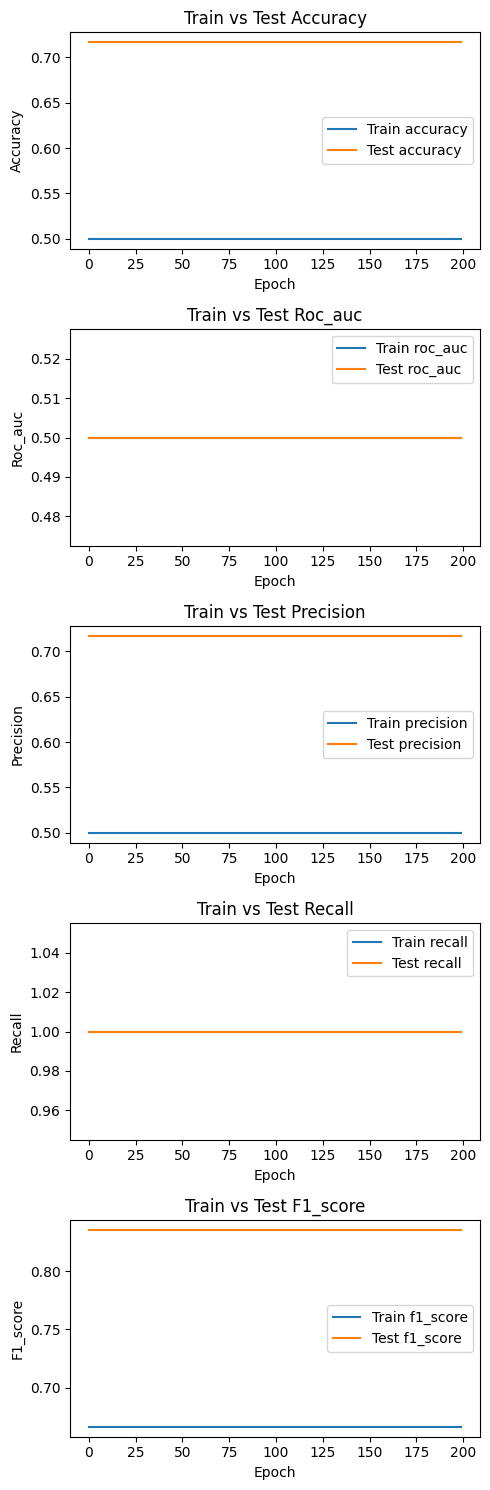

In [ ]:
epochs_range = list(range(epochs))

fig, ax = plt.subplots(5, 1, figsize=(5, 15))
metrics_list = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics_list):
    ax[i].plot(epochs_range, train_metrics[metric], label=f"Train {metric}")
    ax[i].plot(epochs_range, test_metrics[metric], label=f"Test {metric}")
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric.capitalize())
    ax[i].legend()
    ax[i].set_title(f'Train vs Test {metric.capitalize()}')

plt.tight_layout()
plt.show()

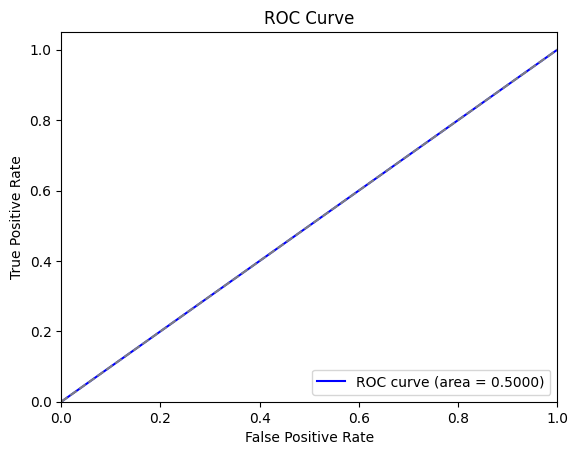

In [ ]:
fpr, tpr, _ = roc_curve(y_test.numpy(), test_preds)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {test_metrics["roc_auc"][-1]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

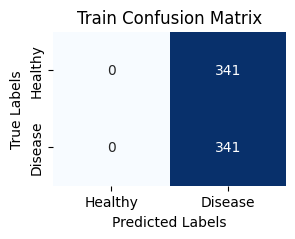

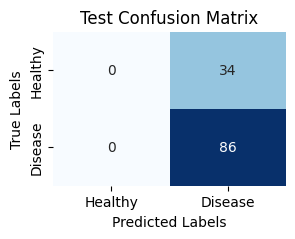

In [ ]:
cm = confusion_matrix(y_train_smote, train_preds)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix')
plt.show()

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

## Shreeya code

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Encoder, self).__init__()
        layers = []
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            print(f"Layer added: {current_dim} -> {hidden_dim}")
            current_dim = hidden_dim
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
            # print(f"After layer {layer}: shape {x.shape}")
        return x

def train_encoder(encoder, data, epochs=50, batch_size=32, learning_rate=0.001, weight_decay=1e-5):
    optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    data_tensor = torch.FloatTensor(data)

    best_loss = float('inf')
    max_epoch = 5
    counter = 0

    for epoch in range(epochs):
        encoder.train()
        total_loss = 0
        for i in range(0, len(data), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            encoded = encoder(batch)
            loss = -torch.mean(torch.abs(encoded))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data)
        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1

        if counter >= max_epoch:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    return encoder


In [ ]:
clinical_encoder = Encoder(input_dim=29, hidden_dims=[8, 4])
print()

biospec_encoder = Encoder(input_dim=5, hidden_dims=[4])
print()

genetic_encoder = Encoder(input_dim=154, hidden_dims=[32, 12, 4])
print()

Layer added: 29 -> 8
Layer added: 8 -> 4

Layer added: 5 -> 4

Layer added: 154 -> 32
Layer added: 32 -> 12
Layer added: 12 -> 4



In [ ]:
print("Training Clinical")
train_encoder(clinical_encoder, X_clinical_train)

print("Training Biospecimen")
train_encoder(biospec_encoder, X_biospec_train)

print("Training Genetic")
train_encoder(genetic_encoder, X_genetic_train)

Training Clinical
Epoch [10/50], Loss: -0.0420, LR: 0.000500
Epoch [20/50], Loss: -0.1076, LR: 0.000250
Epoch [30/50], Loss: -0.1478, LR: 0.000125
Epoch [40/50], Loss: -0.1685, LR: 0.000063
Epoch [50/50], Loss: -0.1787, LR: 0.000031
Training Biospecimen
Epoch [10/50], Loss: -0.0182, LR: 0.000500
Epoch [20/50], Loss: -0.0243, LR: 0.000250
Epoch [30/50], Loss: -0.0274, LR: 0.000125
Epoch [40/50], Loss: -0.0289, LR: 0.000063
Epoch [50/50], Loss: -0.0297, LR: 0.000031
Training Genetic
Epoch [10/50], Loss: -3.7759, LR: 0.000500
Epoch [20/50], Loss: -15.3455, LR: 0.000250
Epoch [30/50], Loss: -24.4332, LR: 0.000125
Epoch [40/50], Loss: -29.4859, LR: 0.000063
Epoch [50/50], Loss: -32.0226, LR: 0.000031


Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=154, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=4, bias=True)
    (5): ReLU()
  )
)

In [ ]:
def extract_features(encoder, data):
    encoder.eval()
    with torch.no_grad():
        return encoder(torch.FloatTensor(data)).numpy()

In [ ]:
X_clinical_train_encoded = extract_features(clinical_encoder, X_clinical_train)
X_biospec_train_encoded = extract_features(biospec_encoder, X_biospec_train)
X_genetic_train_encoded = extract_features(genetic_encoder, X_genetic_train)

X_clinical_test_encoded = extract_features(clinical_encoder, X_clinical_test)
X_biospec_test_encoded = extract_features(biospec_encoder, X_biospec_test)
X_genetic_test_encoded = extract_features(genetic_encoder, X_genetic_test)

X_train_combined = np.hstack((X_clinical_train_encoded, X_biospec_train_encoded, X_genetic_train_encoded))
X_test_combined = np.hstack((X_clinical_test_encoded, X_biospec_test_encoded, X_genetic_test_encoded))

In [ ]:
print(X_clinical_train_encoded.shape)
print(X_biospec_train_encoded.shape)
print(X_genetic_train_encoded.shape)

(478, 4)
(478, 4)
(478, 4)


In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_combined, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 4),
            nn.Dropout(0.2),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

        # self.model = nn.Sequential(
        #     nn.Linear(input_dim, 6),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(6, 1),
        #     nn.Sigmoid()
        # )

    def forward(self, x):
        return self.model(x)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

classifier = Classifier(X_train_combined.shape[1])
criterion = nn.BCELoss(weight=class_weights[1])

learning_rate = 0.0005
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

num_epochs = 300
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_combined), batch_size):
        batch_x = torch.FloatTensor(X_train_combined[i:i + batch_size])
        batch_y = torch.FloatTensor(y_train[i:i + batch_size]).squeeze()

        optimizer.zero_grad()
        outputs = classifier(batch_x).squeeze()

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # scheduler.step(loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.3927
Epoch [20/300], Loss: 0.4395
Epoch [30/300], Loss: 0.5107
Epoch [40/300], Loss: 0.4281
Epoch [50/300], Loss: 0.4395
Epoch [60/300], Loss: 0.4457
Epoch [70/300], Loss: 0.4484
Epoch [80/300], Loss: 0.4682
Epoch [90/300], Loss: 0.4605
Epoch [100/300], Loss: 0.4519
Epoch [110/300], Loss: 0.4317
Epoch [120/300], Loss: 0.4518
Epoch [130/300], Loss: 0.4495
Epoch [140/300], Loss: 0.4716
Epoch [150/300], Loss: 0.4469
Epoch [160/300], Loss: 0.4289
Epoch [170/300], Loss: 0.4821
Epoch [180/300], Loss: 0.4676
Epoch [190/300], Loss: 0.4480
Epoch [200/300], Loss: 0.4447
Epoch [210/300], Loss: 0.4655
Epoch [220/300], Loss: 0.4744
Epoch [230/300], Loss: 0.4680
Epoch [240/300], Loss: 0.4428
Epoch [250/300], Loss: 0.4442
Epoch [260/300], Loss: 0.4304
Epoch [270/300], Loss: 0.4269
Epoch [280/300], Loss: 0.4635
Epoch [290/300], Loss: 0.4455
Epoch [300/300], Loss: 0.4526


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

classifier = Classifier(X_train_combined.shape[1])
criterion = nn.BCELoss(weight=class_weights[1])
initial_lr = 0.0001

optimizer = optim.Adam(classifier.parameters(), lr=initial_lr, weight_decay=1e-5)

num_epochs = 300
batch_size = 32

for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0.0

    for i in range(0, len(X_train_split), batch_size):
        batch_x = torch.FloatTensor(X_train_split[i:i + batch_size])
        batch_y = torch.FloatTensor(y_train_split[i:i + batch_size]).squeeze()

        optimizer.zero_grad()
        outputs = classifier(batch_x).squeeze()

        loss = criterion(outputs, batch_y)
        optimizer.step()

        epoch_loss += loss.item()

    classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val_split), batch_size):
            val_x = torch.FloatTensor(X_val_split[i:i + batch_size])
            val_y = torch.FloatTensor(y_val_split[i:i + batch_size]).squeeze()

            val_outputs = classifier(val_x).squeeze()
            val_loss += criterion(val_outputs, val_y).item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / (len(X_train_split) // batch_size):.4f}, Val Loss: {val_loss / (len(X_val_split) // batch_size):.4f}')

Epoch [10/300], Train Loss: 17.4414, Val Loss: 14.4857
Epoch [20/300], Train Loss: 17.1766, Val Loss: 14.4857
Epoch [30/300], Train Loss: 15.7892, Val Loss: 14.4857
Epoch [40/300], Train Loss: 18.8178, Val Loss: 14.4857
Epoch [50/300], Train Loss: 18.8325, Val Loss: 14.4857
Epoch [60/300], Train Loss: 18.0339, Val Loss: 14.4857
Epoch [70/300], Train Loss: 18.5486, Val Loss: 14.4857
Epoch [80/300], Train Loss: 18.6788, Val Loss: 14.4857
Epoch [90/300], Train Loss: 18.8287, Val Loss: 14.4857
Epoch [100/300], Train Loss: 18.7348, Val Loss: 14.4857
Epoch [110/300], Train Loss: 17.9620, Val Loss: 14.4857
Epoch [120/300], Train Loss: 18.0661, Val Loss: 14.4857
Epoch [130/300], Train Loss: 18.9997, Val Loss: 14.4857
Epoch [140/300], Train Loss: 18.9984, Val Loss: 14.4857
Epoch [150/300], Train Loss: 17.5745, Val Loss: 14.4857
Epoch [160/300], Train Loss: 18.3571, Val Loss: 14.4857
Epoch [170/300], Train Loss: 16.9731, Val Loss: 14.4857
Epoch [180/300], Train Loss: 19.0153, Val Loss: 14.4857
E

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_train_np = X_train_combined
y_train_np = y_train

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_np, y_train_np, test_size=0.1, random_state=42, stratify=y_train_np
)


In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_split), torch.FloatTensor(y_train_split))
val_dataset = TensorDataset(torch.FloatTensor(X_val_split), torch.FloatTensor(y_val_split))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

classifier = Classifier(X_train_combined.shape[1])

initial_lr = 0.001
optimizer = optim.Adam(classifier.parameters(), lr=initial_lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
criterion = FocalLoss(alpha=1, gamma=2)
num_epochs = 100

for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Convert to tensor only before passing to the model
        outputs = classifier(inputs)
        loss = criterion(outputs, labels.view(-1, 1).float())  # Reshape labels if needed

        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = classifier(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1).float()).item()  # Reshape if needed

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch [1/100], Train Loss: 14.3779, Val Loss: 1.8444
Epoch [2/100], Train Loss: 11.4386, Val Loss: 1.1663
Epoch [3/100], Train Loss: 8.5150, Val Loss: 0.7740
Epoch [4/100], Train Loss: 5.3907, Val Loss: 0.4541
Epoch [5/100], Train Loss: 3.0491, Val Loss: 0.3124
Epoch [6/100], Train Loss: 1.2847, Val Loss: 0.1513
Epoch [7/100], Train Loss: 0.4957, Val Loss: 0.1505
Epoch [8/100], Train Loss: 0.2117, Val Loss: 0.1646
Epoch [9/100], Train Loss: 0.1645, Val Loss: 0.1597
Epoch [10/100], Train Loss: 0.1600, Val Loss: 0.1554
Epoch [11/100], Train Loss: 0.1588, Val Loss: 0.1522
Epoch [12/100], Train Loss: 0.1554, Val Loss: 0.1504
Epoch [13/100], Train Loss: 0.1545, Val Loss: 0.1491
Epoch [14/100], Train Loss: 0.1536, Val Loss: 0.1480
Epoch [15/100], Train Loss: 0.1536, Val Loss: 0.1472
Epoch [16/100], Train Loss: 0.1534, Val Loss: 0.1467
Epoch [17/100], Train Loss: 0.1528, Val Loss: 0.1463
Epoch [18/100], Train Loss: 0.1519, Val Loss: 0.1459
Epoch [19/100], Train Loss: 0.1528, Val Loss: 0.1456


In [ ]:
classifier.eval()
with torch.no_grad():
    y_pred = classifier(torch.FloatTensor(X_test_combined)).squeeze()
    y_pred_binary = (y_pred > 0.5).float()

AUC-ROC =  0.5
AUC-PR =  0.7166666666666667
F1 score =  0.8349514563106796
Precision =  0.7166666666666667
Recall =  1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.72      1.00      0.83        86

    accuracy                           0.72       120
   macro avg       0.36      0.50      0.42       120
weighted avg       0.51      0.72      0.60       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


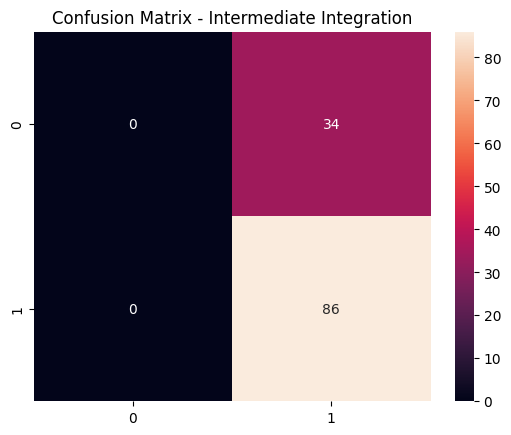

In [ ]:
y_pred_np = y_pred.numpy()
y_pred_binary_np = y_pred_binary.numpy()

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_np))
print("AUC-PR = ", average_precision_score(y_test, y_pred_np))
print("F1 score = ", f1_score(y_test, y_pred_binary_np))
print("Precision = ", precision_score(y_test, y_pred_binary_np))
print("Recall = ", recall_score(y_test, y_pred_binary_np))
print(classification_report(y_test, y_pred_binary_np))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_binary_np)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Intermediate Integration")
plt.show()

In [ ]:
torch.save(clinical_encoder.state_dict(), location + 'encoder_clinical.pth')
torch.save(biospec_encoder.state_dict(), location + 'encoder_biospec.pth')
torch.save(genetic_encoder.state_dict(), location + 'encoder_genetic.pth')
torch.save(classifier.state_dict(), location + 'intermediate_integration_classifier.pth')
print("Intermediate Integration models saved")

Intermediate Integration models saved


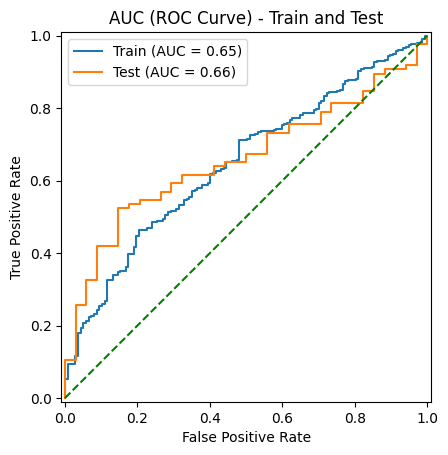

In [ ]:
with torch.no_grad():
    y_train_pred = classifier(torch.FloatTensor(X_train_combined)).squeeze()
    y_test_pred = classifier(torch.FloatTensor(X_test_combined)).squeeze()


ax = plt.gca()
RocCurveDisplay.from_predictions(y_train, y_train_pred.numpy(), name="Train", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_test_pred.numpy(), name="Test", ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Train and Test")
plt.show()

Shreeya Code - Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(current_dim, hidden_dim))
            encoder_layers.append(nn.LeakyReLU())
            current_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        for i in range(len(hidden_dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            decoder_layers.append(nn.LeakyReLU())
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def train_autoencoder(autoencoder, data, epochs=50, batch_size=32, learning_rate=0.001, weight_decay=1e-5):
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.MSELoss()
    data_tensor = torch.FloatTensor(data)

    best_loss = float('inf')
    max_epoch = 5
    counter = 0

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0
        for i in range(0, len(data), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            _, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data)
        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1

        if counter >= max_epoch:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    return autoencoder

# Create and train autoencoders
clinical_autoencoder = Autoencoder(input_dim=29, hidden_dims=[20, 16, 8, 4])
biospec_autoencoder = Autoencoder(input_dim=5, hidden_dims=[4])
genetic_autoencoder = Autoencoder(input_dim=154, hidden_dims=[128, 64, 32, 16, 4])

print("Training Clinical Autoencoder")
train_autoencoder(clinical_autoencoder, X_clinical_train, epochs=100)

print("Training Biospecimen Autoencoder")
train_autoencoder(biospec_autoencoder, X_biospec_train)

print("Training Genetic Autoencoder")
train_autoencoder(genetic_autoencoder, X_genetic_train, epochs=100)

def extract_features(autoencoder, data):
    autoencoder.eval()
    with torch.no_grad():
        encoded, _ = autoencoder(torch.FloatTensor(data))
        return encoded.numpy()

X_clinical_train_encoded = extract_features(clinical_autoencoder, X_clinical_train)
X_biospec_train_encoded = extract_features(biospec_autoencoder, X_biospec_train)
X_genetic_train_encoded = extract_features(genetic_autoencoder, X_genetic_train)

X_clinical_test_encoded = extract_features(clinical_autoencoder, X_clinical_test)
X_biospec_test_encoded = extract_features(biospec_autoencoder, X_biospec_test)
X_genetic_test_encoded = extract_features(genetic_autoencoder, X_genetic_test)

X_train_combined = np.hstack((X_clinical_train_encoded, X_biospec_train_encoded, X_genetic_train_encoded))
X_test_combined = np.hstack((X_clinical_test_encoded, X_biospec_test_encoded, X_genetic_test_encoded))

print(X_clinical_train_encoded.shape)
print(X_biospec_train_encoded.shape)
print(X_genetic_train_encoded.shape)

Training Clinical Autoencoder
Epoch [10/100], Loss: 0.0272, LR: 0.000500
Epoch [20/100], Loss: 0.0244, LR: 0.000250
Epoch [30/100], Loss: 0.0240, LR: 0.000125
Epoch [40/100], Loss: 0.0237, LR: 0.000063
Epoch [50/100], Loss: 0.0234, LR: 0.000031
Epoch [60/100], Loss: 0.0233, LR: 0.000016
Epoch [70/100], Loss: 0.0232, LR: 0.000008
Epoch [80/100], Loss: 0.0231, LR: 0.000004
Epoch [90/100], Loss: 0.0231, LR: 0.000002
Epoch [100/100], Loss: 0.0231, LR: 0.000001
Training Biospecimen Autoencoder
Epoch [10/50], Loss: 0.0232, LR: 0.000500
Epoch [20/50], Loss: 0.0182, LR: 0.000250
Epoch [30/50], Loss: 0.0159, LR: 0.000125
Epoch [40/50], Loss: 0.0148, LR: 0.000063
Epoch [50/50], Loss: 0.0143, LR: 0.000031
Training Genetic Autoencoder
Epoch [10/100], Loss: 0.0314, LR: 0.000500
Epoch [20/100], Loss: 0.0314, LR: 0.000250
Early stopping at epoch 26
(478, 4)
(478, 4)
(478, 4)


In [ ]:
(X_train_combined.shape)

(478, 12)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16, 8]):
        super(Classifier, self).__init__()
        layers = []
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(0.3))
            current_dim = hidden_dim
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_classifier(classifier, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=32, learning_rate=0.001):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        classifier.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        classifier.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = classifier(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = classifier.state_dict()

        if (epoch + 1) % 10 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    classifier.load_state_dict(best_model)
    return classifier

# Usage
input_dim = X_train_combined.shape[1]
classifier = Classifier(input_dim)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_combined, y_train, test_size=0.15, random_state=42, stratify=y_train
)

trained_classifier = train_classifier(classifier, X_train_split, y_train_split, X_val_split, y_val_split)

# Evaluate the model
trained_classifier.eval()
with torch.no_grad():
    y_pred = trained_classifier(torch.FloatTensor(X_test_combined)).squeeze()
    y_pred_binary = (y_pred > 0.5).float()

y_pred_np = y_pred.numpy()
y_pred_binary_np = y_pred_binary.numpy()



Epoch [10/100], Train Loss: 0.5468, Val Loss: 0.5514
Epoch [20/100], Train Loss: 0.4893, Val Loss: 0.5049
Epoch [30/100], Train Loss: 0.4392, Val Loss: 0.4693
Epoch [40/100], Train Loss: 0.4441, Val Loss: 0.4743
Epoch [50/100], Train Loss: 0.4376, Val Loss: 0.4787
Epoch [60/100], Train Loss: 0.4270, Val Loss: 0.4825
Epoch [70/100], Train Loss: 0.4332, Val Loss: 0.4769
Epoch [80/100], Train Loss: 0.4360, Val Loss: 0.4809
Epoch [90/100], Train Loss: 0.4254, Val Loss: 0.4825
Epoch [100/100], Train Loss: 0.4250, Val Loss: 0.4792


AUC-ROC =  0.8372093023255814
AUC-PR =  0.9341755723368157
F1 score =  0.8522727272727273
Precision =  0.8333333333333334
Recall =  0.872093023255814
              precision    recall  f1-score   support

           0       0.63      0.56      0.59        34
           1       0.83      0.87      0.85        86

    accuracy                           0.78       120
   macro avg       0.73      0.72      0.72       120
weighted avg       0.78      0.78      0.78       120



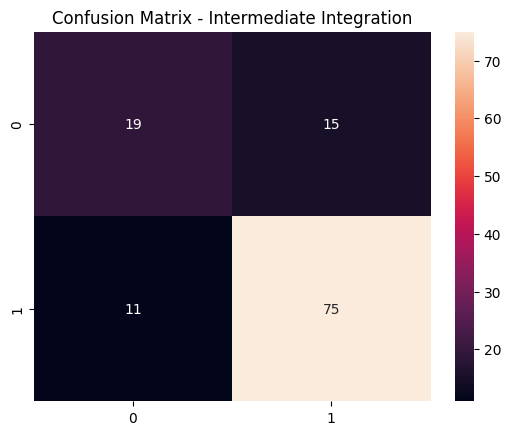

In [ ]:
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_np))
print("AUC-PR = ", average_precision_score(y_test, y_pred_np))
print("F1 score = ", f1_score(y_test, y_pred_binary_np))
print("Precision = ", precision_score(y_test, y_pred_binary_np))
print("Recall = ", recall_score(y_test, y_pred_binary_np))
print(classification_report(y_test, y_pred_binary_np))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_binary_np)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Intermediate Integration")
plt.show()

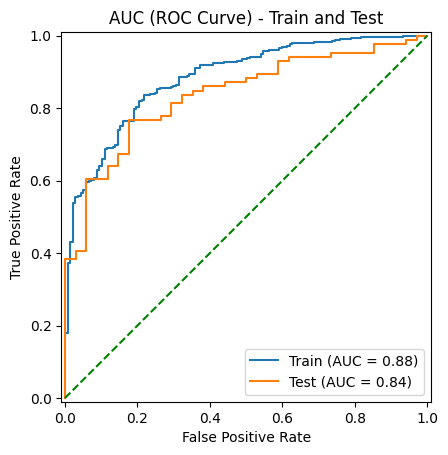

In [ ]:
with torch.no_grad():
    y_train_pred = trained_classifier(torch.FloatTensor(X_train_combined)).squeeze()
    y_test_pred = trained_classifier(torch.FloatTensor(X_test_combined)).squeeze()


ax = plt.gca()
RocCurveDisplay.from_predictions(y_train, y_train_pred.numpy(), name="Train", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_test_pred.numpy(), name="Test", ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Train and Test")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Training function with k-fold cross-validation
def train_with_cv(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Normalize data
        scaler = StandardScaler()
        X_train_normalized = scaler.fit_transform(X_train_resampled)
        X_val_normalized = scaler.transform(X_val)

        # Train autoencoder
        autoencoder = Autoencoder(X_train_normalized.shape[1], [64, 32, 16])
        train_autoencoder(autoencoder, X_train_normalized)

        # Extract features
        X_train_encoded = extract_features(autoencoder, X_train_normalized)
        X_val_encoded = extract_features(autoencoder, X_val_normalized)

        # Train classifier
        classifier = Classifier(X_train_encoded.shape[1], [32, 16])
        train_classifier(classifier, X_train_encoded, y_train_resampled, X_val_encoded, y_val)

        models.append((autoencoder, classifier, scaler))

    return models

# Use the trained models for prediction
def predict_with_ensemble(models, X_test):
    predictions = []
    for autoencoder, classifier, scaler in models:
        X_test_normalized = scaler.transform(X_test)
        X_test_encoded = extract_features(autoencoder, X_test_normalized)
        pred = classifier(torch.FloatTensor(X_test_encoded)).squeeze().detach().numpy()
        predictions.append(pred)
    return np.mean(predictions, axis=0)

# Train the models
models = train_with_cv(X_train_combined, y_train)

Epoch [10/50], Loss: 0.0022, LR: 0.000500
Epoch [20/50], Loss: 0.0010, LR: 0.000250
Epoch [30/50], Loss: 0.0005, LR: 0.000125
Epoch [40/50], Loss: 0.0004, LR: 0.000063
Epoch [50/50], Loss: 0.0003, LR: 0.000031
Epoch [10/100], Train Loss: 0.4438, Val Loss: 0.4696
Epoch [20/100], Train Loss: 0.4356, Val Loss: 0.4414
Epoch [30/100], Train Loss: 0.4463, Val Loss: 0.4384
Epoch [40/100], Train Loss: 0.4219, Val Loss: 0.4502
Epoch [50/100], Train Loss: 0.4438, Val Loss: 0.4443
Epoch [60/100], Train Loss: 0.4091, Val Loss: 0.4465
Epoch [70/100], Train Loss: 0.4365, Val Loss: 0.4471
Epoch [80/100], Train Loss: 0.4230, Val Loss: 0.4469
Epoch [90/100], Train Loss: 0.4144, Val Loss: 0.4438
Epoch [100/100], Train Loss: 0.4379, Val Loss: 0.4454
Epoch [10/50], Loss: 0.0025, LR: 0.000500
Epoch [20/50], Loss: 0.0012, LR: 0.000250
Epoch [30/50], Loss: 0.0010, LR: 0.000125
Epoch [40/50], Loss: 0.0009, LR: 0.000063
Epoch [50/50], Loss: 0.0009, LR: 0.000031
Epoch [10/100], Train Loss: 0.5077, Val Loss: 0.4

AUC-ROC = 0.8433652530779754
AUC-PR = 0.9334546565880982
F1 score = 0.8280254777070064
Precision = 0.9154929577464789
Recall = 0.7558139534883721
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.92      0.76      0.83        86

    accuracy                           0.78       120
   macro avg       0.74      0.79      0.75       120
weighted avg       0.82      0.78      0.78       120



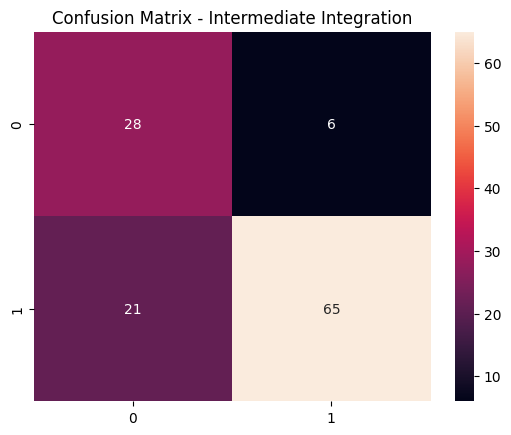

In [ ]:

# Make predictions
y_pred = predict_with_ensemble(models, X_test_combined)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
print("AUC-ROC =", roc_auc_score(y_test, y_pred))
print("AUC-PR =", average_precision_score(y_test, y_pred))
print("F1 score =", f1_score(y_test, y_pred_binary))
print("Precision =", precision_score(y_test, y_pred_binary))
print("Recall =", recall_score(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Intermediate Integration")
plt.show()



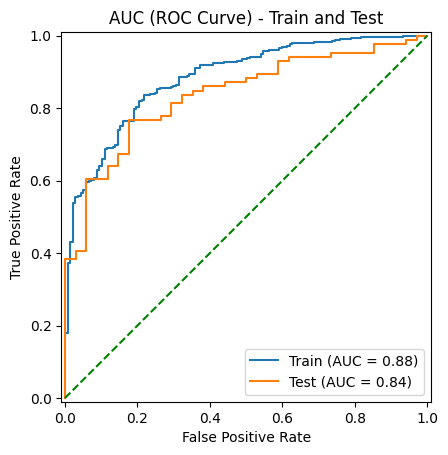

In [ ]:
ax = plt.gca()
RocCurveDisplay.from_predictions(y_train, y_train_pred.numpy(), name="Train", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_test_pred.numpy(), name="Test", ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Train and Test")
plt.show()